In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import json
import os
import numpy as np
from tqdm import tqdm
import cv2

In [29]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.concat([x1, x2], 1)
        return self.conv(x)

In [30]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_colors=8):
        super().__init__()
        self.color_embedding = nn.Embedding(num_colors, 64)
        self.down_convlution_1 = DownSample(in_channels + 1, 64)
        self.down_convlution_2 = DownSample(64, 128)
        self.down_convlution_3 = DownSample(128, 256)
        self.down_convlution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x, color_idx):
        batch_size, channels, h, w = x.shape

        color_emb = self.color_embedding(color_idx)
        color_emb = color_emb.view(batch_size, 64, 1, 1)
        color_emb = color_emb.expand(batch_size, 64, h, w)
        color_channel = torch.mean(color_emb, dim=1, keepdim=True)

        x = torch.cat([x, color_channel], dim=1)

        down_1, p1 = self.down_convlution_1(x)
        down_2, p2 = self.down_convlution_2(p1)
        down_3, p3 = self.down_convlution_3(p2)
        down_4, p4 = self.down_convlution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)

        return out

In [31]:
class PolygonDataset(Dataset):
    def __init__(self, data_json_path, inputs_dir, outputs_dir, transform=None, augment=False):
        with open(data_json_path, 'r') as f:
            self.data = json.load(f)

        self.inputs_dir = inputs_dir
        self.outputs_dir = outputs_dir
        self.transform = transform
        self.augment = augment

        # Create color to index mapping
        self.colors = list(set(item['colour'] for item in self.data))
        self.color_to_idx = {color: idx for idx, color in enumerate(self.colors)}
        self.num_colors = len(self.colors)

        print(f"Found {len(self.data)} samples with {self.num_colors} unique colors: {self.colors}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Load input polygon image
        input_path = os.path.join(self.inputs_dir, item['input_polygon'])
        input_img = Image.open(input_path).convert('RGB')

        # Load output colored polygon image
        output_path = os.path.join(self.outputs_dir, item['output_image'])
        output_img = Image.open(output_path).convert('RGB')

        # Get color index
        color_idx = self.color_to_idx[item['colour']]

        if self.transform:
            # Apply same transform to both input and output
            seed = np.random.randint(2147483647)

            # Transform input
            torch.manual_seed(seed)
            np.random.seed(seed)
            input_tensor = self.transform(input_img)

            # Transform output with same seed
            torch.manual_seed(seed)
            np.random.seed(seed)
            output_tensor = self.transform(output_img)
        else:
            to_tensor = transforms.ToTensor()
            input_tensor = to_tensor(input_img)
            output_tensor = to_tensor(output_img)

        return {
            'input': input_tensor,
            'output': output_tensor,
            'color_idx': color_idx,
            'color_name': item['colour']
        }

In [32]:
def create_synthetic_polygons(num_samples=1000, image_size=128):
    """Generate synthetic polygon dataset for data augmentation"""
    synthetic_data = []
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    color_values = {
        'red': (255, 0, 0),
        'blue': (0, 0, 255),
        'green': (0, 255, 0),
        'yellow': (255, 255, 0),
        'purple': (128, 0, 128),
        'orange': (255, 165, 0),
        'cyan': (0, 255, 255),
        'magenta': (255, 0, 255)
    }

    os.makedirs('synthetic/inputs', exist_ok=True)
    os.makedirs('synthetic/outputs', exist_ok=True)

    for i in range(num_samples):
        # Random polygon parameters
        num_sides = np.random.randint(3, 9)  # 3 to 8 sides
        center = (image_size // 2, image_size // 2)
        radius = np.random.randint(50, 100)
        color_name = np.random.choice(colors)
        color_value = color_values[color_name]

        # Generate polygon points
        angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
        points = []
        for angle in angles:
            # Add some randomness to make irregular polygons
            r = radius + np.random.randint(-20, 20)
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            points.append([x, y])

        points = np.array(points, dtype=np.int32)

        # Create input image (outline only)
        input_img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        cv2.polylines(input_img, [points], True, (255, 255, 255), 2)

        # Create output image (filled polygon)
        output_img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        cv2.fillPoly(output_img, [points], color_value)

        # Save images
        input_filename = f'synthetic_input_{i:04d}.png'
        output_filename = f'synthetic_output_{i:04d}.png'

        cv2.imwrite(f'synthetic/inputs/{input_filename}', input_img)
        cv2.imwrite(f'synthetic/outputs/{output_filename}', output_img)

        synthetic_data.append({
            'input': input_filename,
            'output': output_filename,
            'color': color_name
        })

    # Save synthetic data.json
    with open('synthetic/data.json', 'w') as f:
        json.dump(synthetic_data, f, indent=2)

    print(f"Generated {num_samples} synthetic polygon samples")
    return synthetic_data

In [33]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 150
IMAGE_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])
augment_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ])


# Create the training dataset to get the full color mapping
train_dataset = PolygonDataset(
        '/content/drive/MyDrive/ConditionalUNet/dataset/training/data.json',
        '/content/drive/MyDrive/ConditionalUNet/dataset/training/inputs',
        '/content/drive/MyDrive/ConditionalUNet/dataset/training/outputs',
        transform=transform
    )

# Use the color mapping from the training dataset for the validation dataset
val_dataset = PolygonDataset(
        '/content/drive/MyDrive/ConditionalUNet/dataset/validation/data.json',
        '/content/drive/MyDrive/ConditionalUNet/dataset/validation/inputs',
        '/content/drive/MyDrive/ConditionalUNet/dataset/validation/outputs',
        transform=transform
    )
try:
    synthetic_dataset = PolygonDataset(
            'synthetic/data.json',
            'synthetic/inputs',
            'synthetic/outputs',
            transform=augment_transform,
            augment=True
        )

        # Combine datasets
    from torch.utils.data import ConcatDataset
    combined_dataset = ConcatDataset([train_dataset, synthetic_dataset])
    print(f"Combined dataset size: {len(combined_dataset)}")

    train_dataset = combined_dataset
except:
      print("Synthetic data not found, using original dataset only")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

num_colors = len(train_dataset.colors)

model = UNet(num_colors=num_colors).to(device)
optimizer = optim.AdamW(model.parameters(), lr =LEARNING_RATE, weight_decay=0.01)
criterion = nn.MSELoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')

    for batch in train_pbar:
        inputs = batch['input'].to(device)
        targets = batch['output'].to(device)
        color_indices = batch['color_idx'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, color_indices)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

        # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for batch in val_pbar:
            inputs = batch['input'].to(device)
            targets = batch['output'].to(device)
            color_indices = batch['color_idx'].to(device)

            outputs = model(inputs, color_indices)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'color_to_idx': train_dataset.color_to_idx,
            'colors': train_dataset.colors
        }, '/content/drive/MyDrive/ConditionalUNet/models/best_model.pth')

Found 56 samples with 8 unique colors: ['yellow', 'red', 'cyan', 'magenta', 'green', 'blue', 'purple', 'orange']
Found 5 samples with 4 unique colors: ['yellow', 'blue', 'cyan', 'green']
Synthetic data not found, using original dataset only


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 150/150 [Val]: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s, loss=0.0366]


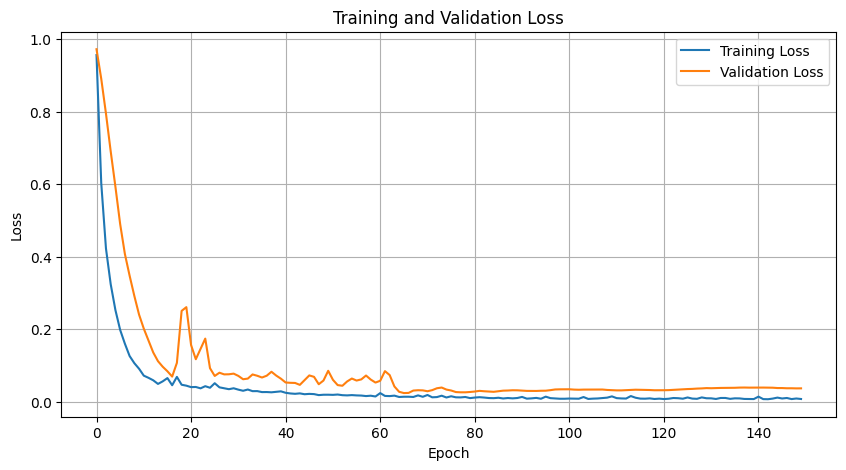

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


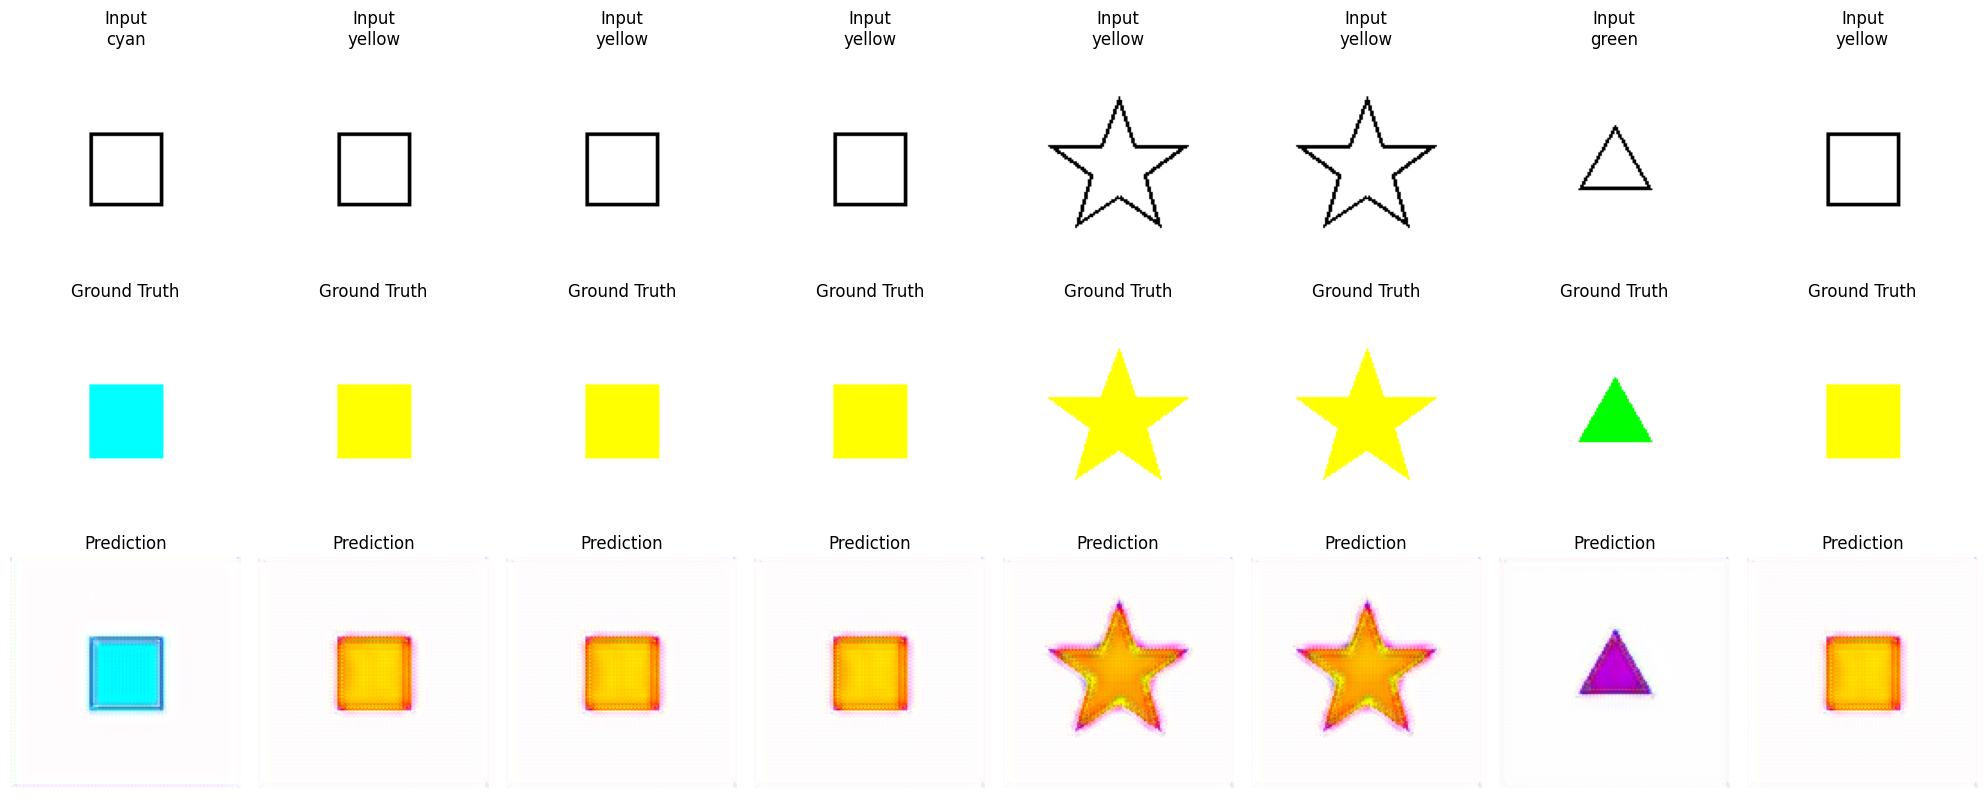

In [34]:
import matplotlib.pyplot as plt
def visualize_results(model, dataset, num_samples=8):
    """Visualize model predictions"""
    model.eval()

    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8))

    with torch.no_grad():
        for i in range(num_samples):
            # Get a random sample
            idx = np.random.randint(len(dataset))
            sample = dataset[idx]

            input_img = sample['input'].unsqueeze(0).to(device)
            color_idx = torch.tensor([sample['color_idx']]).to(device)
            target_img = sample['output']

            # Generate prediction
            pred_img = model(input_img, color_idx)

            # Convert tensors to numpy for visualization
            input_np = input_img.squeeze().cpu().permute(1, 2, 0).numpy()
            target_np = target_img.permute(1, 2, 0).numpy()
            pred_np = pred_img.squeeze().cpu().permute(1, 2, 0).numpy()

            # Plot
            axes[0, i].imshow(input_np)
            axes[0, i].set_title(f'Input\n{sample["color_name"]}')
            axes[0, i].axis('off')

            axes[1, i].imshow(target_np)
            axes[1, i].set_title('Ground Truth')
            axes[1, i].axis('off')

            axes[2, i].imshow(pred_np)
            axes[2, i].set_title('Prediction')
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('results_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
visualize_results(model, val_dataset)